# Python notebook: Analysing data and ploting figures
## Import packages
"""
Last update on December 2025

@author: jlittaye
Python 3.11.5
"""

In [1]:
import os
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import random
from math import *
import time
import sys
import pandas as pd
import scipy.signal
import datetime

import torch
from torch import optim, nn, utils, Tensor
from torchviz import make_dot, make_dot_from_trace
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from func_file import Hovmoller_plot, calcul_MLDmax, linear_interpolate_1d, metrics_BGC, get_topcorner, get_rightcorner, Model_NNPZD_1D
from model_file import UNet_param_forcing_state
devices = ['cpu']+[f"cuda:{idevice}" for idevice in range(torch.cuda.device_count())]
torch.set_default_device(devices[-1])

## Concatenate DA/hybrid members into ensemble

In [33]:
case = 1 # forcing uncertainty level (0, 1, 2 or 3)
obs_ch = [10]*5 # States time sampling
obs_strat = 1 # Observation strategy, defines states vertical sampling

# path_in = f"Res/hybrid/Case{case}_1sample{obs_ch[0]}days_strat{obs_strat}/"
# path_out = f"Res/hybrid/Ensemble/Case{case}_1sample{obs_ch[0]}days_strat{obs_strat}/"
path_in = f"Res/DA/Case{case}_1sample{obs_ch[0]}days_strat{obs_strat}/"
path_out = f"Res/DA/Ensemble/Case{case}_1sample{obs_ch[0]}days_strat{obs_strat}/"

if not os.path.isdir(path_out+"pred_var/") :
    os.makedirs(path_out+"pred_var/")

Kz = torch.tensor([]).to(devices[-1])
I0 = torch.tensor([]).to(devices[-1])
States0 = torch.tensor([]).to(devices[-1])
Params = torch.tensor([]).to(devices[-1])
States = torch.tensor([]).to(devices[-1])

nb_version = 0
for file in np.sort(os.listdir(path_in)) :
    if file[:8]=="Version_" :
        States0_i = torch.load(path_in+file+"/States0_visu.pt", weights_only=False, map_location='cuda')[-1:].clone()
        States_i = torch.load(path_in+file+"/States_pred.pt", weights_only=False, map_location='cuda').clone()
        States_i = torch.cat([States_i[:, :, sub, :-1] for sub in range(States_i.shape[2])], dim=2)
        Params_i = torch.load(path_in+file+"/Params_visu.pt", weights_only=False, map_location='cuda')[-1:].clone()
        torch.save(Params_i.clone(), path_in+file+"/Params_pred.pt")
        torch.save(States0_i.clone(), path_in+file+"/States0_pred.pt")
        Kz = torch.cat((Kz, torch.load(path_in+file+"/Kz.pt", weights_only=False, map_location='cuda')[None]),dim=0)
        I0 = torch.cat((I0, torch.load(path_in+file+"/I0.pt", weights_only=False, map_location='cuda')[None]),dim=0)
        States0 = torch.cat((States0, States0_i),dim=0)
        Params = torch.cat((Params, Params_i),dim=0)
        States = torch.cat((States, States_i[None]),dim=0)
        print(file)
    else :
        print("not a file_version :", file)

print(Kz.shape)
print(I0.shape)
print(Params.shape)
print(States0.shape)
print(States.shape)
    
torch.save(Kz, path_out+"Kz.pt")
torch.save(I0, path_out+"I0.pt")
torch.save(Params, path_out+"pred_var/Params_pred_ens.pt")
torch.save(States0, path_out+"pred_var/States0_pred_ens.pt")
torch.save(States, path_out+"pred_var/States_pred_ens.pt")


params = torch.load(path_out+"pred_var/Params_pred_ens.pt", weights_only=False, map_location=devices[-1]).mean(0)

I0_test = torch.load(f"Generated_Datasets/Case_{case}/I0.pt", weights_only=False, map_location=devices[-1])[0, -100:]
Kz_test = torch.load(f"Generated_Datasets/Case_{case}/Kz.pt", weights_only=False, map_location=devices[-1])[0, -100:]
States_ref = torch.load(f"Generated_Datasets/Case_{case}/States.pt", weights_only=False, map_location=devices[-1])[-100:]
z_ref = torch.from_numpy(np.load("FORCING_40km/depth.npy"))[0, :States_ref.shape[-1]].to(devices[-1])
zw_ref = torch.from_numpy(np.load("FORCING_40km/depthw.npy"))[0, :Kz_test.shape[-1]].to(devices[-1])

Model_BGC = Model_NNPZD_1D(params, torch.arange(0, 3*365, (30/60)/24), z_ref, zw_ref, Kz_test.repeat(1, 3, 1), I0_test.repeat(1, 3))
Model_BGC.eval()
Model_BGC.to(devices[-1])
Model_BGC.device = devices[-1]
with torch.no_grad() :
    Model_BGC.NO3_0 = States_ref[:, 0, 0, None].clone().to(devices[-1])
    Model_BGC.NH4_0 = States_ref[:, 1, 0, None].clone().to(devices[-1])
    Model_BGC.P_0 = States_ref[:, 2, 0, None].clone().to(devices[-1])
    Model_BGC.Z_0 = States_ref[:, 3, 0, None].clone().to(devices[-1])
    Model_BGC.D_0 = States_ref[:, 4, 0, None].clone().to(devices[-1])
    States, Itz, _m = Model_BGC(sub_windows = torch.arange(0, 365*3, 1)[None], info_time=True)

torch.save(States[:, :, 0], path_out+"pred_var/States_reconstruct.pt")


Step 1094/1095. Ends in 0:00:00.197925s

In [ ]:

# list_scenario = [
#                # "Case1_1sample1days_strat1/",
#                # "Case1_1sample10days_strat1/",
#                # "Case1_1sample30days_strat1/",
#                # "Case1_1sample60days_strat1/",
#                # "Case1_1sample10days_strat0/",
#                # "Case1_1sample10days_strat2/",
#                # "Case1_1sample10days_strat3/",
#                "Case2_1sample10days_strat1/",
#                "Case3_1sample10days_strat1/"
#                   ]

# zmax = 350
# Nz = np.argmin(np.load("FORCING_40km/depth.npy")[0] < zmax)
# z_ref = torch.from_numpy(np.load("FORCING_40km/depth.npy")[0, :Nz]).to(devices[-1])
# zw_ref = torch.from_numpy(np.load("FORCING_40km/depthw.npy")[0, :Nz+1]).to(devices[-1])

# for path_save in list_scenario :
#     # print(path_save, torch.load("Res/NN/"+path_save+"Version_0/pred_var/States_reconstruct.pt", weights_only=False).shape)

#     case = int(path_save.split("_")[0][-1])
#     params_res = torch.load("Res/NN/"+path_save+"Version_0/pred_var/Params_pred_ens.pt", weights_only=False, map_location=devices[-1])
#     I0_test = torch.load(f"Generated_Datasets/Case_{case}/I0.pt", weights_only=False, map_location=devices[-1])[0, -100:]
#     Kz_test = torch.load(f"Generated_Datasets/Case_{case}/Kz.pt", weights_only=False, map_location=devices[-1])[0, -100:]
#     States_ref = torch.load(f"Generated_Datasets/Case_{case}/States.pt", weights_only=False, map_location=devices[-1])[-100:]
    
#     Model_BGC = Model_NNPZD_1D(params_res.mean(dim=0).clone().to(devices[-1]), torch.arange(0, 3*365, (30/60)/24), z_ref.to(devices[-1]), zw_ref.to(devices[-1]), Kz_test.repeat(1, 3, 1), I0_test.repeat(1, 3))
#     Model_BGC.eval()
#     Model_BGC.to(devices[-1])
#     Model_BGC.device = devices[-1]
#     with torch.no_grad() :
#         Model_BGC.NO3_0 = States_ref[:, 0, 0, None].clone().to(devices[-1])
#         Model_BGC.NH4_0 = States_ref[:, 1, 0, None].clone().to(devices[-1])
#         Model_BGC.P_0 = States_ref[:, 2, 0, None].clone().to(devices[-1])
#         Model_BGC.Z_0 = States_ref[:, 3, 0, None].clone().to(devices[-1])
#         Model_BGC.D_0 = States_ref[:, 4, 0, None].clone().to(devices[-1])
#         States, Itz, Kz = Model_BGC(sub_windows = torch.arange(0, 365*3, 1)[None], info_time=True)
    
#     torch.save(States.clone()[:, :, 0].cpu(), "Res/NN/"+path_save+"Version_0/pred_var/States_reconstruct.pt")
#     print("\nStates reconstructed for ", path_save, " with shape : ", States.shape,"\n")

# Plot stock estimation/analysis DA, NN, NN+DA

In [32]:
torch.set_default_device(devices[0])

path = 'FORCING_40km/'
zmax = 350
Nz = np.argmin(np.load(path+"depth.npy")[0] < zmax)

case = 1
obs_ch = [10]*5
obs_strat = 1
if obs_strat == 1 :
    i_z_ch = [[i for i in range(34)], [5, 11, 15, 20, 24, 27, 33], [i for i in range(34)], [5, 11, 15, 20, 24, 27, 33], [i for i in range(34)]]
    obs_strat_name = "CTD+Rosette"
elif obs_strat == 2 :
    i_z_ch = [[i for i in range(34)], [], [i for i in range(34)], [], [i for i in range(34)]]
    obs_strat_name = "CTD"
elif obs_strat == 3 :
    i_z_ch = [[5, 11, 15, 20, 24, 27, 33]]*5
    obs_strat_name = "Rosette"

for ch in range(len(obs_ch)) :
    if len(i_z_ch[ch]) == 0 :
        obs_ch[ch] = 0
dt_ch = [int(dt_ch/0.5) for dt_ch in obs_ch]

if not os.path.exists(f"Generated_Datasets/Case_{case}/States_ens.pt") :
    params = torch.load(f"Generated_Datasets/Case_{case}/Params.pt", weights_only=False, map_location=devices[-1])[0, -100:]
    z_ref = torch.from_numpy(np.load("FORCING_40km/depth.npy")[0, :Nz]).to(devices[-1])
    zw_ref = torch.from_numpy(np.load("FORCING_40km/depthw.npy")[0, :Nz+1]).to(devices[-1])
    
    States_true = torch.tensor([], device=devices[0])
    I0_test = torch.load(f"Generated_Datasets/Case_{case}/I0_ens.pt", weights_only=False, map_location=devices[-1])[1]
    Kz_test = torch.load(f"Generated_Datasets/Case_{case}/Kz_ens.pt", weights_only=False, map_location=devices[-1])[1]
    States_ref = torch.load(f"Generated_Datasets/Case_{case}/States.pt", weights_only=False, map_location=devices[-1])[-100:]
    for m in range(I0_test.shape[0]) :
        Model_BGC = Model_NNPZD_1D(params, torch.arange(0, 3*365, (30/60)/24), z_ref, zw_ref, Kz_test[m].repeat(1, 3, 1), I0_test[m].repeat(1, 3))
        Model_BGC.eval()
        Model_BGC.to(devices[-1])
        Model_BGC.device = devices[-1]
        with torch.no_grad() :
            Model_BGC.NO3_0 = States_ref[:, 0, 0, None].clone().to(devices[-1])
            Model_BGC.NH4_0 = States_ref[:, 1, 0, None].clone().to(devices[-1])
            Model_BGC.P_0 = States_ref[:, 2, 0, None].clone().to(devices[-1])
            Model_BGC.Z_0 = States_ref[:, 3, 0, None].clone().to(devices[-1])
            Model_BGC.D_0 = States_ref[:, 4, 0, None].clone().to(devices[-1])
            States_m, Itz_m, Kz_m = Model_BGC(sub_windows = torch.arange(365*2, 365*3, 1)[None], info_time=True)
        States_true = torch.cat([States_true, States_m[None].to(devices[0])],dim=0)
        print(f"\nMember {m+1}/10\n")
    torch.save(States_true.clone()[:, :, :, 0].cpu(), f"Generated_Datasets/Case_{case}/States_ens.pt")


## States true ##
States_true = torch.load(f"Generated_Datasets/Case_{case}/States.pt", weights_only=False, map_location=devices[0])[-100:, :, -335:-215]
## States DA ##
path_DA = f"Res/DA/Ensemble/Case{case}_1sample{obs_ch[0]}days_strat{obs_strat}/"
States_DA = torch.load(path_DA+f"pred_var/States_pred_ens.pt", weights_only=False, map_location=devices[0]).detach()
## States Obs ##
list_d0 = torch.load(f"Generated_Datasets/Case_0/list_d0_sampling{obs_ch[0]}d.pt", weights_only=False, map_location=devices[0])
States_obs = torch.load(f"Generated_Datasets/Case_{case}/States_noised.pt", weights_only=False, map_location=devices[0])
## States NN ##
path_NN = f"Res/NN/Case{case}_1sample{obs_ch[0]}days_strat{obs_strat}/"
nb_version = -1
for file in os.listdir(path_NN) :
    if file[:8] == "Version_" :
        nb_version += 1
path_NN += f"Version_{nb_version}/"
States_NN = torch.load(path_NN+f"pred_var/States_pred_ens.pt", weights_only=False, map_location=devices[0]).detach()
## States NN+DA ##
path_hybrid = f"Res/hybrid/Ensemble/Case{case}_1sample{obs_ch[0]}days_strat{obs_strat}/"
States_hybrid = torch.load(path_hybrid+f"pred_var/States_pred_ens.pt", weights_only=False, map_location=devices[0]).detach()

z_ref = torch.from_numpy(np.load(path+"depth.npy")[0, :Nz]).to(devices[0])
zw_ref = torch.from_numpy(np.load(path+"depthw.npy")[0, :Nz+1]).to(devices[0])

n = random.randint(0, 99) # for the plots select n=[31, 35, 55]
for n in [31, 35, 55] :
    print(f"Sample {n}")
    fig, ax = plt.subplots(figsize = [6.4*3, 4.8*0.7*5], nrows=5, ncols=3, sharex=True)
    for ch in range(5) :
        for i in range(3) :
            ax[ch, i].plot(torch.arange(30, 150, 1), torch.sum(States_true[n, ch]*(zw_ref[1:]-zw_ref[:-1]), dim=1), color = 'k', label = 'Ground truth')
            ax[ch, i].plot(torch.arange(30+list_d0[n], 150, obs_ch[0]), torch.sum(States_obs[n, ch, list_d0[n]:]*(zw_ref[1:]-zw_ref[:-1]), dim=1).unfold(0, 1, obs_ch[0]).flatten(0), color = 'red', label = 'Observation', ls=' ', marker='o')
            
            ax[ch, i].grid()
            ax[ch, i].set_title(["NO3", "NH4", "P", "Z", "D"][ch], fontsize=16)
            ax[ch, i].set_xticks(ticks=[30, 60, 90, 120, 150], labels=["February", "March", "April", "May", "June"], fontsize=14)
            ax[ch, 0].set_ylabel(r"Nitrogen stock ($mmol.m^{-2}$)", fontsize=14)
            
        ax[ch, 0].fill_between(x=np.arange(30, 150, 1), y1=torch.max(torch.tensor([0.]).cpu(), torch.sum((States_DA[:, n, ch].mean(dim=0)-2*States_DA[:, n, ch].std(dim=0))*(zw_ref[1:]-zw_ref[:-1]),dim=1)).cpu(), y2=torch.sum((States_DA[:, n, ch].mean(dim=0)+2*States_DA[:, n, ch].std(dim=0))*(zw_ref[1:]-zw_ref[:-1]),dim=1).cpu(), color = 'blue', alpha=0.35)
        ax[ch, 0].plot(np.arange(30, 150, 1), torch.sum(States_DA.mean(dim=0)[n, ch]*(zw_ref[1:]-zw_ref[:-1]), dim=1), label = '4Dvar', lw=3, color='blue')
    
        ax[ch, 1].fill_between(x=np.arange(30, 150, 1), y1=torch.max(torch.tensor([0.]).cpu(), torch.sum((States_NN[:, n, ch].mean(dim=0)-2*States_NN[:, n, ch].std(dim=0))*(zw_ref[1:]-zw_ref[:-1]),dim=1)).cpu(), y2=torch.sum((States_NN[:, n, ch].mean(dim=0)+2*States_NN[:, n, ch].std(dim=0))*(zw_ref[1:]-zw_ref[:-1]),dim=1).cpu(), color = 'orange', alpha=0.35)
        ax[ch, 1].plot(np.arange(30, 150, 1), torch.sum(States_NN.mean(dim=0)[n, ch]*(zw_ref[1:]-zw_ref[:-1]), dim=1), label = 'U-Net', lw=3, color='orange')
        
        ax[ch, 2].fill_between(x=np.arange(30, 150, 1), y1=torch.max(torch.tensor([0.]).cpu(), torch.sum((States_hybrid[:, n, ch].mean(dim=0)-2*States_hybrid[:, n, ch].std(dim=0))*(zw_ref[1:]-zw_ref[:-1]),dim=1)).cpu(), y2=torch.sum((States_hybrid[:, n, ch].mean(dim=0)+2*States_hybrid[:, n, ch].std(dim=0))*(zw_ref[1:]-zw_ref[:-1]),dim=1).cpu(), color = 'green', alpha=0.35)
        ax[ch, 2].plot(np.arange(30, 150, 1), torch.sum(States_hybrid.mean(dim=0)[n, ch]*(zw_ref[1:]-zw_ref[:-1]), dim=1), label = 'U-Net + 4Dvar', lw=3, color='green')
        
    for i in range(3) :
        ax[0, i].legend(fontsize=18, loc='upper right')
        for ch in range(5) :
            if ch > 0 :
                limmin, limmax = 0., round((torch.sum(States_true[n, ch]*(zw_ref[1:]-zw_ref[:-1]), dim=1).max()*1.2).item())
            else :
                limmin, limmax = round((torch.sum(States_true[n, ch]*(zw_ref[1:]-zw_ref[:-1]), dim=1).min()*0.9).item()), round((torch.sum(States_true[n, ch]*(zw_ref[1:]-zw_ref[:-1]), dim=1).max()*1.05).item())
            ax[ch, i].set_ylim(limmin, limmax)
    
    fig.tight_layout()
    fig.savefig(f"Stock_reanalysis_sample{n}", dpi = 500)

## Print metrics

In [34]:
std_states = torch.load("Generated_Datasets/Case_0/States_std.pt", weights_only=False, map_location=devices[0])
mean_states = torch.load("Generated_Datasets/Case_0/States_mean.pt", weights_only=False, map_location=devices[0])

NMSE_DA = torch.mean(((States_DA.mean(0)-States_true).moveaxis(1, 3)/std_states)**2, dim=(0, 1, 2))
NMSE_NN = torch.mean(((States_NN.mean(0)-States_true).moveaxis(1, 3)/std_states)**2, dim=(0, 1, 2))
NMSE_hybrid = torch.mean(((States_hybrid.mean(0)-States_true).moveaxis(1, 3)/std_states)**2, dim=(0, 1, 2))

std_DA = States_DA.std(0).mean(dim=(0, 2, 3))
std_NN = States_NN.std(0).mean(dim=(0, 2, 3))
std_hybrid = States_hybrid.std(0).mean(dim=(0, 2, 3))

Repres_DA = torch.sum((States_true > States_DA.mean(0)-2*States_DA.std(0))*(States_true < States_DA.mean(0)+2*States_DA.std(0)), dim=(0, 2, 3))/(States_true.shape[0]*States_true.shape[2]*States_true.shape[3])
Repres_NN = torch.sum((States_true > States_NN.mean(0)-2*States_NN.std(0))*(States_true < States_NN.mean(0)+2*States_NN.std(0)), dim=(0, 2, 3))/(States_true.shape[0]*States_true.shape[2]*States_true.shape[3])
Repres_hybrid = torch.sum((States_true > States_hybrid.mean(0)-2*States_hybrid.std(0))*(States_true < States_hybrid.mean(0)+2*States_hybrid.std(0)), dim=(0, 2, 3))/(States_true.shape[0]*States_true.shape[2]*States_true.shape[3])


print(f"\nStates DA :\nNMSE : NO3={NMSE_DA[0].item():.3f}, NH4={NMSE_DA[1].item():.3f}, P={NMSE_DA[2].item():.3f}, Z={NMSE_DA[3].item():.3f}, D={NMSE_DA[4].item():.3f}",
      f"\nStd : NO3={std_DA[0].item():.3f}, NH4={std_DA[1].item():.3f}, P={std_DA[2].item():.3f}, Z={std_DA[3].item():.3f}, D={std_DA[4].item():.3f}",
      f"\nRepresentativeness : NO3={100*Repres_DA[0].item():.1f}, NH4={100*Repres_DA[1].item():.1f}, P={100*Repres_DA[2].item():.1f}, Z={100*Repres_DA[3].item():.1f}, D={100*Repres_DA[4].item():.1f}")

print(f"\nStates NN :\nNMSE : NO3={NMSE_NN[0].item():.3f}, NH4={NMSE_NN[1].item():.3f}, P={NMSE_NN[2].item():.3f}, Z={NMSE_NN[3].item():.3f}, D={NMSE_NN[4].item():.3f}",
      f"\nStd : NO3={std_NN[0].item():.3f}, NH4={std_NN[1].item():.3f}, P={std_NN[2].item():.3f}, Z={std_NN[3].item():.3f}, D={std_NN[4].item():.3f}",
      f"\nRepresentativeness : NO3={100*Repres_NN[0].item():.1f}, NH4={100*Repres_NN[1].item():.1f}, P={100*Repres_NN[2].item():.1f}, Z={100*Repres_NN[3].item():.1f}, D={100*Repres_NN[4].item():.1f}")

print(f"\nStates hybrid :\nNMSE : NO3={NMSE_hybrid[0].item():.3f}, NH4={NMSE_hybrid[1].item():.3f}, P={NMSE_hybrid[2].item():.3f}, Z={NMSE_hybrid[3].item():.3f}, D={NMSE_hybrid[4].item():.3f}",
      f"\nStd : NO3={std_hybrid[0].item():.3f}, NH4={std_hybrid[1].item():.3f}, P={std_hybrid[2].item():.3f}, Z={std_hybrid[3].item():.3f}, D={std_hybrid[4].item():.3f}",
      f"\nRepresentativeness : NO3={100*Repres_hybrid[0].item():.1f}, NH4={100*Repres_hybrid[1].item():.1f}, P={100*Repres_hybrid[2].item():.1f}, Z={100*Repres_hybrid[3].item():.1f}, D={100*Repres_hybrid[4].item():.1f}")


States DA :
NMSE : NO3=0.012, NH4=0.062, P=0.241, Z=0.032, D=0.103 
Std : NO3=0.083, NH4=0.004, P=0.052, Z=0.040, D=0.015 
Representativeness : NO3=40.7, NH4=44.1, P=46.3, Z=34.8, D=44.4

States NN :
NMSE : NO3=0.007, NH4=0.033, P=0.084, Z=0.017, D=0.048 
Std : NO3=0.058, NH4=0.002, P=0.054, Z=0.051, D=0.019 
Representativeness : NO3=60.1, NH4=39.6, P=79.3, Z=73.8, D=76.2

States hybrid :
NMSE : NO3=0.022, NH4=0.030, P=0.047, Z=0.008, D=0.036 
Std : NO3=0.143, NH4=0.007, P=0.067, Z=0.073, D=0.026 
Representativeness : NO3=68.1, NH4=88.4, P=85.3, Z=78.4, D=82.9


In [46]:
States_i = torch.load("Res/NN/Case1_1sample10days_strat1/Version_0/pred_var/States_init.pt", weights_only=False)
Params_i = torch.load("Generated_Datasets/Case_0/Params.pt", weights_only=False)[1, -100:]
Params_true = torch.load("Generated_Datasets/Case_0/Params.pt", weights_only=False)[0, -100:]

print(f"NMSE states init : {torch.mean(((States_i.mean(0)-States_true).moveaxis(1, 3)/std_states)**2):.3f}")
print(f"NMSE params init (DA) : {torch.mean(((Params_i.mean(0)-Params_true)/std_params)**2):.3f}")

NMSE states init : 0.769
NMSE params init (DA) : 1.045


# Violin plot

## Comp DA/NN

In [2]:
list_file_name = [
                  f"Res/DA/Ensemble/Case1_1sample10days_strat1/",
                  f"Res/NN/Case1_1sample10days_strat1/Version_0/"
                 ]
nb_case_stud = len(list_file_name)
States_stud = torch.tensor([], device=devices[0])
Params_stud = torch.tensor([], device=devices[0])
folder_name = ""
for i in range(nb_case_stud) :
    nb_version = -1
    for file in os.listdir(folder_name+list_file_name[i]) :
        if file[:8] == "Version_" :
            nb_version += 1
    States_stud = torch.cat((States_stud, torch.load(folder_name+list_file_name[i]+f"pred_var/States_reconstruct.pt", weights_only=False, map_location=devices[0])[None, :, :, -365:]), dim = 0)
    Params_stud = torch.cat((Params_stud, torch.load(folder_name+list_file_name[i]+f"pred_var/Params_pred_ens.pt", weights_only=False, map_location=devices[0]).mean(0)[None]), dim = 0)

States_ref = torch.load(f"Generated_Datasets/Case_{1}/States.pt", weights_only=False, map_location=devices[0])[-100:, :, -365:].clone()
Params_ref=torch.load(f"Generated_Datasets/Case_{1}/Params.pt", weights_only=False, map_location=devices[0])[0, -100:]
mean_params=torch.load("Generated_Datasets/Case_0/Params_mean.pt", weights_only=False, map_location=devices[0])
std_params=torch.load("Generated_Datasets/Case_0/Params_std.pt", weights_only=False, map_location=devices[0])

zmax = 350
N_sample = 100
path = 'FORCING_40km/'
Nz = np.argmin(np.load(path+"depth.npy")[0] < zmax)
zrangew_Kz = torch.from_numpy(np.load(path+"depthw.npy"))
z_ref = torch.from_numpy(np.load(path+"depth.npy")[0, :Nz])
zw_ref = torch.from_numpy(np.load(path+"depthw.npy")[0, :Nz+1])

print("Files loaded")

Files loaded


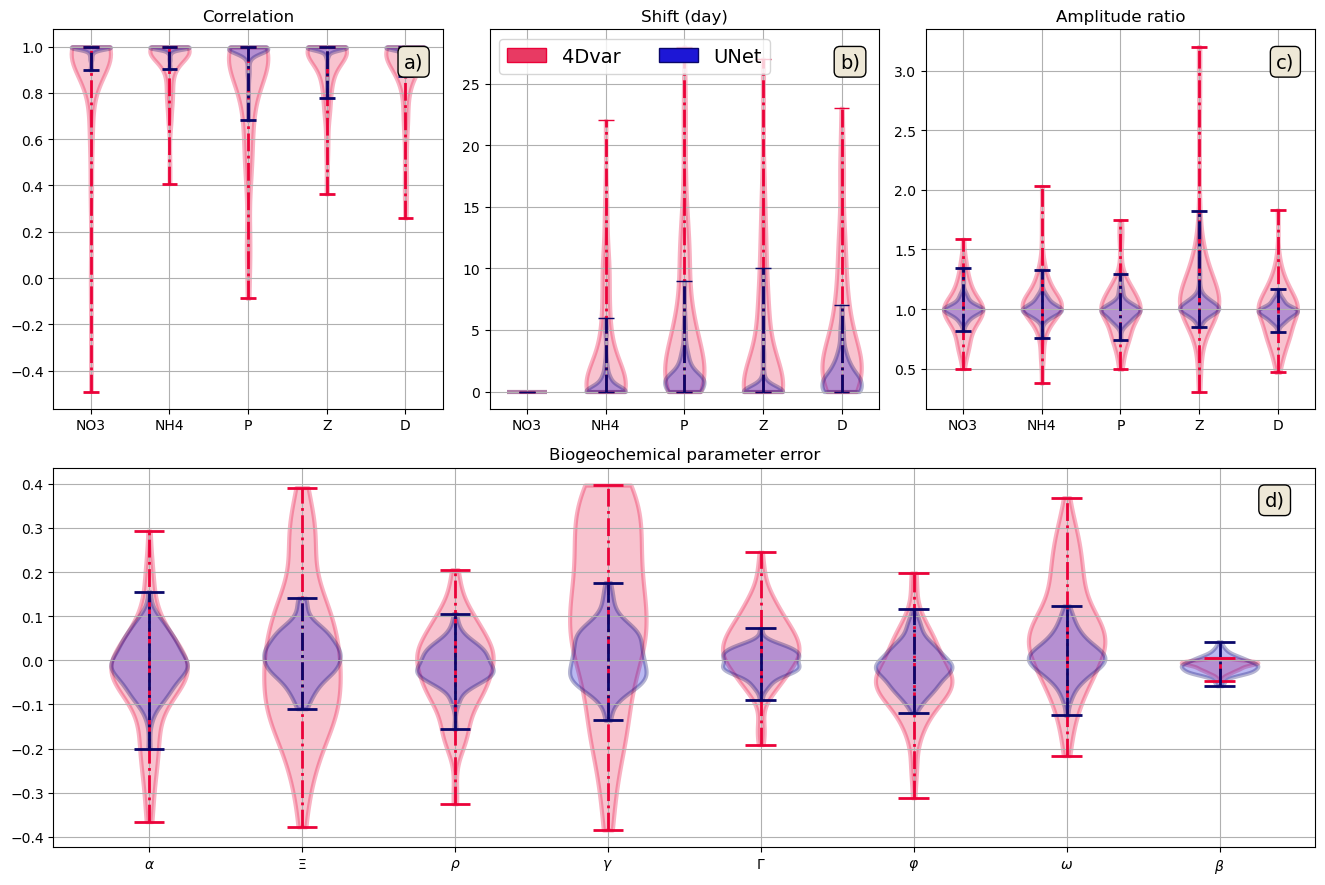

In [3]:
## Colors DA vs NN
label_case = [f"4Dvar", f"UNet"]
colors = [["#e83a63", "#eb0239"], ['#1d17d6', '#0a0769']] # red, db
fig_file_name = "Violin_plot_comp_DA_NN.png"



fig = plt.figure(figsize=(6.4*2.1, 6.4*0.7*2))
grid = fig.add_gridspec(nrows = 2, ncols=3)
ax_corr = fig.add_subplot(grid[0, 0])
ax_shift = fig.add_subplot(grid[0, 1])
ax_ampl = fig.add_subplot(grid[0, 2])
ax_param = fig.add_subplot(grid[1, :])

ax_corr.set_title('Correlation')
# ax_corr.set_ylim(0.15, 1.05)
ax_shift.set_title('Shift (day)')
# ax_shift.set_ylim(-2, 31)
ax_ampl.set_title("Amplitude ratio")
# ax_ampl.set_ylim(0.2, 2.6)
ax_param.set_title("Biogeochemical parameter error")
# ax_param.set_ylim(-0.42, 0.42)
c_DA, s_DA, r_DA, v_DA = [], [], [], []

compteur = 0
corr, shift, ampl = [], [], []
for i in range(nb_case_stud) :
    corr_step, shift_step, ampl_step = metrics_BGC(torch.sum(States_stud[i, :, :, 30:150]*(zw_ref[1:]-zw_ref[:-1]), dim = -1), torch.sum(States_ref[:, :, 30:150]*(zw_ref[1:]-zw_ref[:-1]), dim = -1))
    corr.append(corr_step.cpu()); shift.append(shift_step.cpu()); ampl.append(ampl_step.cpu())

    c_DA.append(ax_corr.violinplot(corr[i], showextrema=False))
    s_DA.append(ax_shift.violinplot(abs(shift[i]), showextrema=False))
    r_DA.append(ax_ampl.violinplot(ampl[i], showextrema=False))
    v_DA.append(ax_param.violinplot(((Params_stud[i]-Params_ref)/mean_params), showextrema=False))

for j in range(nb_case_stud) :
    for i in range(8) :
        ax_param.vlines(i+1, ((Params_stud[j]-Params_ref)/mean_params)[:, i].min().item(), ((Params_stud[j]-Params_ref)/mean_params)[:, i].max().item(), color=colors[j][1], linestyle='-.', lw=2)
        ax_param.hlines(((Params_stud[j]-Params_ref)/mean_params)[:, i].min().item(), xmin = i+0.9, xmax = i+1.1, color=colors[j][1], linestyle='-', lw=2)
        ax_param.hlines(((Params_stud[j]-Params_ref)/mean_params)[:, i].max().item(), xmin = i+0.9, xmax = i+1.1, color=colors[j][1], linestyle='-', lw=2)

    for i in range(5) :
        ax_corr.vlines(i+1, corr[j][ :, i].min().item(), corr[j][ :, i].max().item(), color=colors[j][1], linestyle='-.', lw=2)
        ax_corr.hlines(corr[j][ :, i].min().item(), xmin = i+0.9, xmax = i+1.1, color=colors[j][1], linestyle='-', lw=2)
        ax_corr.hlines(corr[j][ :, i].max().item(), xmin = i+0.9, xmax = i+1.1, color=colors[j][1], linestyle='-', lw=2)
    
        ax_shift.vlines(i+1, abs(shift[j])[ :, i].min().item(), abs(shift[j])[ :, i].max().item(), color=colors[j][1], linestyle='-.', lw=2)
        ax_shift.hlines(abs(shift[j])[ :, i].min().item(), xmin = i+0.9, xmax = i+1.1, color=colors[j][1], lw=1)
        ax_shift.hlines(abs(shift[j])[ :, i].max().item(), xmin = i+0.9, xmax = i+1.1, color=colors[j][1], lw=1)
    
        ax_ampl.vlines(i+1, ampl[j][ :, i].min().item(), ampl[j][ :, i].max().item(), color=colors[j][1], linestyle='-.', lw=2)
        ax_ampl.hlines(ampl[j][ :, i].min().item(), xmin = i+0.9, xmax = i+1.1, color=colors[j][1], linestyle='-', lw=2)
        ax_ampl.hlines(ampl[j][ :, i].max().item(), xmin = i+0.9, xmax = i+1.1, color=colors[j][1], linestyle='-', lw=2)
    
for compteur in range(nb_case_stud) :
    for pc in v_DA[compteur]['bodies']:
        pc.set_facecolor(colors[compteur][0])
        pc.set_edgecolor(colors[compteur][1])
        pc.set_linewidth(3)
    for pc in c_DA[compteur]['bodies']:
        pc.set_facecolor(colors[compteur][0])
        pc.set_edgecolor(colors[compteur][1])
        pc.set_linewidth(3)
    for pc in s_DA[compteur]['bodies']:
        pc.set_facecolor(colors[compteur][0])
        pc.set_edgecolor(colors[compteur][1])
        pc.set_linewidth(3)
    for pc in r_DA[compteur]['bodies']:
        pc.set_facecolor(colors[compteur][0])
        pc.set_edgecolor(colors[compteur][1])
        pc.set_linewidth(3)


ax_corr.text(s = "a)", x = get_rightcorner(ax_corr, 0.9), y = get_topcorner(ax_corr, 0.9), bbox = dict(boxstyle="round", fc="#eee8d7", alpha = 1), fontsize = 14)
ax_shift.text(s = "b)", x = get_rightcorner(ax_shift, 0.9), y = get_topcorner(ax_shift, 0.9), bbox = dict(boxstyle="round", fc="#eee8d7", alpha = 1), fontsize = 14)
ax_ampl.text(s = "c)", x = get_rightcorner(ax_ampl, 0.9), y = get_topcorner(ax_ampl, 0.9), bbox = dict(boxstyle="round", fc="#eee8d7", alpha = 1), fontsize = 14)
ax_param.text(s = "d)", x = get_rightcorner(ax_param, 0.96), y = get_topcorner(ax_param, 0.9), bbox = dict(boxstyle="round", fc="#eee8d7", alpha = 1), fontsize = 14)

comp_legend=[]
for i in range(nb_case_stud) :
    comp_legend.append(mpatches.Patch(color=colors[i][0], ec = colors[i][1], label=label_case[i]))

ax_shift.legend(handles=comp_legend, loc = 'upper left', fontsize = 14, ncol=2)
for ax in [ax_corr, ax_shift, ax_ampl] :
    ax.grid()
    ax.set_xticks([1, 2, 3, 4, 5], ["NO3", "NH4", "P", "Z", "D"])

ax_param.grid()
ax_param.set_xticks(torch.arange(1, 9, 1).cpu(), [r"$\alpha$", r"$\Xi$", r"$\rho$", r"$\gamma$", r"$\Gamma$", r"$\varphi$", r"$\omega$", r"$\beta$"])
plt.rc('axes', titlesize=14)
plt.rc('axes', labelsize=14) #fontsize of the x and y labels
plt.rc('xtick', labelsize=14) #fontsize of the x tick labels
plt.rc('ytick', labelsize=14) #fontsize of the y tick labels

plt.subplots_adjust(bottom=0.15, wspace=0.15)
# fig.suptitle("Case 1 - CTD + Rosette - Daily obs")
fig.tight_layout()

fig.savefig(fig_file_name, dpi=300)


## Case 1, 2, 3

In [19]:
list_file_name = [
                  f"Res/NN/Case3_1sample10days_strat1/",
                  f"Res/NN/Case2_1sample10days_strat1/",
                  f"Res/NN/Case1_1sample10days_strat1/"
                 ]
nb_case_stud = len(list_file_name)
States_stud = torch.tensor([], device=devices[0])
Params_stud = torch.tensor([], device=devices[0])
folder_name = ""
for i in range(nb_case_stud) :
    nb_version = -1
    for file in os.listdir(folder_name+list_file_name[i]) :
        if file[:8] == "Version_" :
            nb_version += 1
    States_stud = torch.cat((States_stud, torch.load(folder_name+list_file_name[i]+f"Version_{nb_version}/pred_var/States_reconstruct.pt", weights_only=False, map_location=devices[0])[None,:, :, -365:]), dim = 0)
    Params_stud = torch.cat((Params_stud, torch.load(folder_name+list_file_name[i]+f"Version_{nb_version}/pred_var/Params_pred_ens.pt", weights_only=False, map_location=devices[0]).mean(0)[None]), dim = 0)

## Actually States_ref and Params_ref are the same for case_0,1,2,3
States_ref = torch.load(f"Generated_Datasets/Case_{0}/States.pt", weights_only=False, map_location=devices[0])[-100:, :, -365:].clone()
Params_ref=torch.load(f"Generated_Datasets/Case_{0}/Params.pt", weights_only=False, map_location=devices[0])[0, -100:]
mean_params=torch.load("Generated_Datasets/Case_0/Params_mean.pt", weights_only=False, map_location=devices[0])
std_params=torch.load("Generated_Datasets/Case_0/Params_std.pt", weights_only=False, map_location=devices[0])

zmax = 350
N_sample = 100
path = 'FORCING_40km/'
Nz = np.argmin(np.load(path+"depth.npy")[0] < zmax)
zrangew_Kz = torch.from_numpy(np.load(path+"depthw.npy"))
z_ref = torch.from_numpy(np.load(path+"depth.npy")[0, :Nz])
zw_ref = torch.from_numpy(np.load(path+"depthw.npy")[0, :Nz+1])

print("Files loaded")

Files loaded


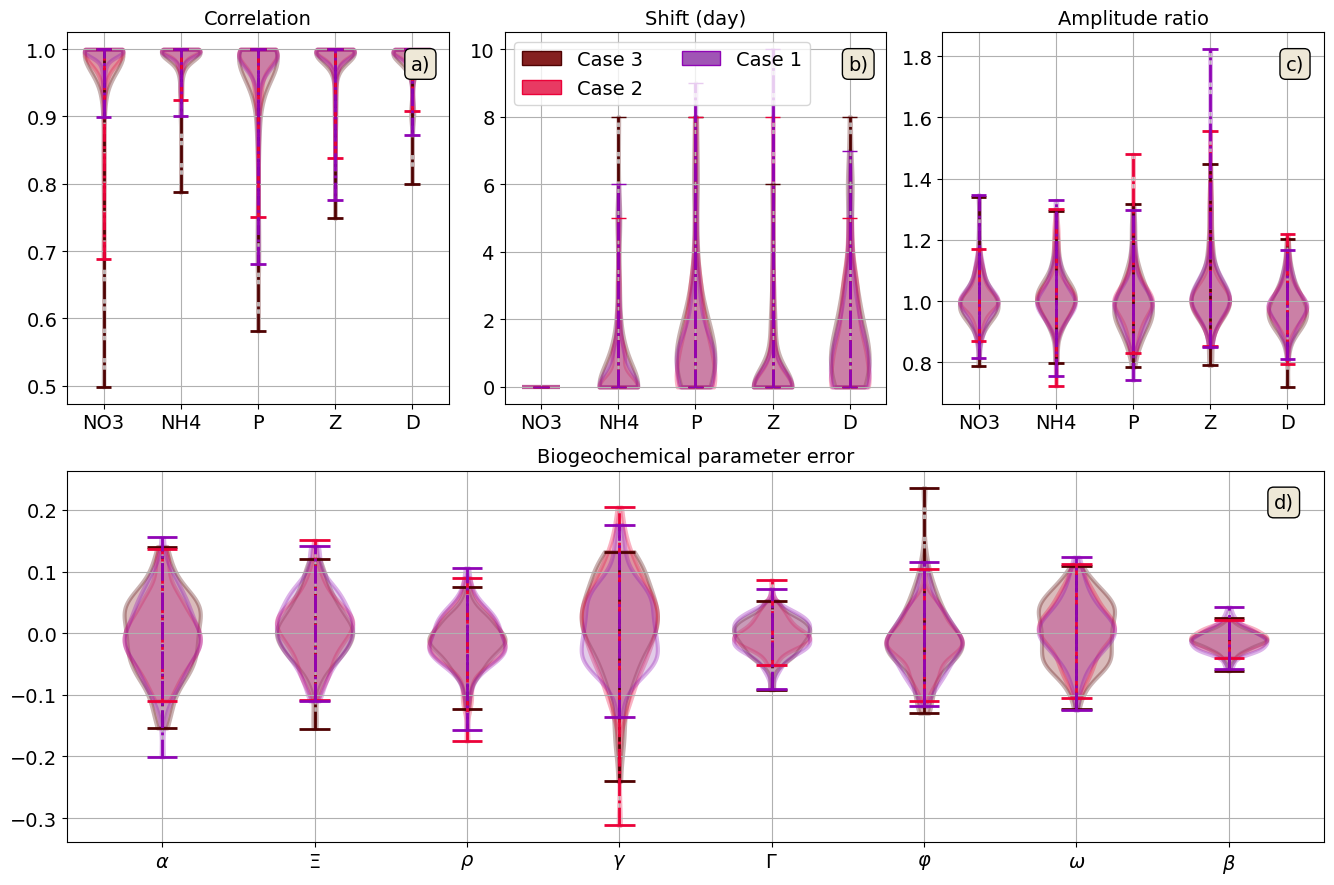

In [20]:
## Colors case -1, 0, 1, 2, 3
label_case = [f"Case 3", f"Case 2", f"Case 1", f"Case 0", f"Case -1"]
colors = [["#852020", "#4f0202"], ["#e83a63", "#eb0239"], ["#a055b5", "#8f04b5"], ['#1d17d6', '#0a0769'], ['#85d1d6', '#0ccaa5']] # brown, red, purple, db, lb
fig_file_name = "Violin_plot_NN_case123_ens.png"


fig = plt.figure(figsize=(6.4*2.1, 6.4*0.7*2))
grid = fig.add_gridspec(nrows = 2, ncols=3)
ax_corr = fig.add_subplot(grid[0, 0])
ax_shift = fig.add_subplot(grid[0, 1])
ax_ampl = fig.add_subplot(grid[0, 2])
ax_param = fig.add_subplot(grid[1, :])

ax_corr.set_title('Correlation')
# ax_corr.set_ylim(0.15, 1.05)
ax_shift.set_title('Shift (day)')
# ax_shift.set_ylim(-2, 31)
ax_ampl.set_title("Amplitude ratio")
# ax_ampl.set_ylim(0.2, 2.6)
ax_param.set_title("Biogeochemical parameter error")
# ax_param.set_ylim(-0.42, 0.42)
c_DA, s_DA, r_DA, v_DA = [], [], [], []

compteur = 0
corr, shift, ampl = [], [], []
for i in range(nb_case_stud) :
    corr_step, shift_step, ampl_step = metrics_BGC(torch.sum(States_stud[i, :, :, 30:150]*(zw_ref[1:]-zw_ref[:-1]), dim = -1), torch.sum(States_ref[:, :, 30:150]*(zw_ref[1:]-zw_ref[:-1]), dim = -1))
    corr.append(corr_step.cpu()); shift.append(shift_step.cpu()); ampl.append(ampl_step.cpu())

    c_DA.append(ax_corr.violinplot(corr[i], showextrema=False))
    s_DA.append(ax_shift.violinplot(abs(shift[i]), showextrema=False))
    r_DA.append(ax_ampl.violinplot(ampl[i], showextrema=False))
    v_DA.append(ax_param.violinplot(((Params_stud[i]-Params_ref)/mean_params), showextrema=False))

for j in range(nb_case_stud) :
    for i in range(8) :
        ax_param.vlines(i+1, ((Params_stud[j]-Params_ref)/mean_params)[:, i].min().item(), ((Params_stud[j]-Params_ref)/mean_params)[:, i].max().item(), color=colors[j][1], linestyle='-.', lw=2)
        ax_param.hlines(((Params_stud[j]-Params_ref)/mean_params)[:, i].min().item(), xmin = i+0.9, xmax = i+1.1, color=colors[j][1], linestyle='-', lw=2)
        ax_param.hlines(((Params_stud[j]-Params_ref)/mean_params)[:, i].max().item(), xmin = i+0.9, xmax = i+1.1, color=colors[j][1], linestyle='-', lw=2)

    for i in range(5) :
        ax_corr.vlines(i+1, corr[j][ :, i].min().item(), corr[j][ :, i].max().item(), color=colors[j][1], linestyle='-.', lw=2)
        ax_corr.hlines(corr[j][ :, i].min().item(), xmin = i+0.9, xmax = i+1.1, color=colors[j][1], linestyle='-', lw=2)
        ax_corr.hlines(corr[j][ :, i].max().item(), xmin = i+0.9, xmax = i+1.1, color=colors[j][1], linestyle='-', lw=2)
    
        ax_shift.vlines(i+1, abs(shift[j])[ :, i].min().item(), abs(shift[j])[ :, i].max().item(), color=colors[j][1], linestyle='-.', lw=2)
        ax_shift.hlines(abs(shift[j])[ :, i].min().item(), xmin = i+0.9, xmax = i+1.1, color=colors[j][1], lw=1)
        ax_shift.hlines(abs(shift[j])[ :, i].max().item(), xmin = i+0.9, xmax = i+1.1, color=colors[j][1], lw=1)
    
        ax_ampl.vlines(i+1, ampl[j][ :, i].min().item(), ampl[j][ :, i].max().item(), color=colors[j][1], linestyle='-.', lw=2)
        ax_ampl.hlines(ampl[j][ :, i].min().item(), xmin = i+0.9, xmax = i+1.1, color=colors[j][1], linestyle='-', lw=2)
        ax_ampl.hlines(ampl[j][ :, i].max().item(), xmin = i+0.9, xmax = i+1.1, color=colors[j][1], linestyle='-', lw=2)
    
for compteur in range(nb_case_stud) :
    for pc in v_DA[compteur]['bodies']:
        pc.set_facecolor(colors[compteur][0])
        pc.set_edgecolor(colors[compteur][1])
        pc.set_linewidth(3)
    for pc in c_DA[compteur]['bodies']:
        pc.set_facecolor(colors[compteur][0])
        pc.set_edgecolor(colors[compteur][1])
        pc.set_linewidth(3)
    for pc in s_DA[compteur]['bodies']:
        pc.set_facecolor(colors[compteur][0])
        pc.set_edgecolor(colors[compteur][1])
        pc.set_linewidth(3)
    for pc in r_DA[compteur]['bodies']:
        pc.set_facecolor(colors[compteur][0])
        pc.set_edgecolor(colors[compteur][1])
        pc.set_linewidth(3)


ax_corr.text(s = "a)", x = get_rightcorner(ax_corr, 0.9), y = get_topcorner(ax_corr, 0.9), bbox = dict(boxstyle="round", fc="#eee8d7", alpha = 1), fontsize = 14)
ax_shift.text(s = "b)", x = get_rightcorner(ax_shift, 0.9), y = get_topcorner(ax_shift, 0.9), bbox = dict(boxstyle="round", fc="#eee8d7", alpha = 1), fontsize = 14)
ax_ampl.text(s = "c)", x = get_rightcorner(ax_ampl, 0.9), y = get_topcorner(ax_ampl, 0.9), bbox = dict(boxstyle="round", fc="#eee8d7", alpha = 1), fontsize = 14)
ax_param.text(s = "d)", x = get_rightcorner(ax_param, 0.96), y = get_topcorner(ax_param, 0.9), bbox = dict(boxstyle="round", fc="#eee8d7", alpha = 1), fontsize = 14)

comp_legend=[]
for i in range(nb_case_stud) :
    comp_legend.append(mpatches.Patch(color=colors[i][0], ec = colors[i][1], label=label_case[i]))

ax_shift.legend(handles=comp_legend, loc = 'upper left', fontsize = 14, ncol=2)
for ax in [ax_corr, ax_shift, ax_ampl] :
    ax.grid()
    ax.set_xticks([1, 2, 3, 4, 5], ["NO3", "NH4", "P", "Z", "D"])

ax_param.grid()
ax_param.set_xticks(torch.arange(1, 9, 1).cpu(), [r"$\alpha$", r"$\Xi$", r"$\rho$", r"$\gamma$", r"$\Gamma$", r"$\varphi$", r"$\omega$", r"$\beta$"])
plt.rc('axes', titlesize=14)
plt.rc('axes', labelsize=14) #fontsize of the x and y labels
plt.rc('xtick', labelsize=14) #fontsize of the x tick labels
plt.rc('ytick', labelsize=14) #fontsize of the y tick labels

plt.subplots_adjust(bottom=0.15, wspace=0.15)
# fig.suptitle("Case 1 - CTD + Rosette - Daily obs")
fig.tight_layout()

fig.savefig(fig_file_name, dpi=300)


## Time sampling

In [2]:
list_file_name = [
                  f"Res/NN/Case1_1sample60days_strat1/",
                  f"Res/NN/Case1_1sample30days_strat1/",
                  f"Res/NN/Case1_1sample10days_strat1/",
                  f"Res/NN/Case1_1sample1days_strat1/"
                 ]
nb_case_stud = len(list_file_name)
States_stud = torch.tensor([], device=devices[0])
Params_stud = torch.tensor([], device=devices[0])
folder_name = ""
for i in range(nb_case_stud) :
    nb_version = -1
    for file in os.listdir(folder_name+list_file_name[i]) :
        if file[:8] == "Version_" :
            nb_version += 1
    States_stud = torch.cat((States_stud, torch.load(folder_name+list_file_name[i]+f"Version_{nb_version}/pred_var/States_reconstruct.pt", weights_only=False, map_location=devices[0])[None, :, :, -365:]), dim = 0)
    Params_stud = torch.cat((Params_stud, torch.load(folder_name+list_file_name[i]+f"Version_{nb_version}/pred_var/Params_pred_ens.pt", weights_only=False, map_location=devices[0]).mean(0)[None]), dim = 0)

States_ref = torch.load(f"Generated_Datasets/Case_{0}/States.pt", weights_only=False, map_location=devices[0])[-100:, :, -365:].clone()
Params_ref=torch.load(f"Generated_Datasets/Case_{0}/Params.pt", weights_only=False, map_location=devices[0])[0, -100:]
mean_params=torch.load("Generated_Datasets/Case_0/Params_mean.pt", weights_only=False, map_location=devices[0])
std_params=torch.load("Generated_Datasets/Case_0/Params_std.pt", weights_only=False, map_location=devices[0])

zmax = 350
N_sample = 100
path = 'FORCING_40km/'
Nz = np.argmin(np.load(path+"depth.npy")[0] < zmax)
zrangew_Kz = torch.from_numpy(np.load(path+"depthw.npy"))
z_ref = torch.from_numpy(np.load(path+"depth.npy")[0, :Nz])
zw_ref = torch.from_numpy(np.load(path+"depthw.npy")[0, :Nz+1])

print("Files loaded")

Files loaded


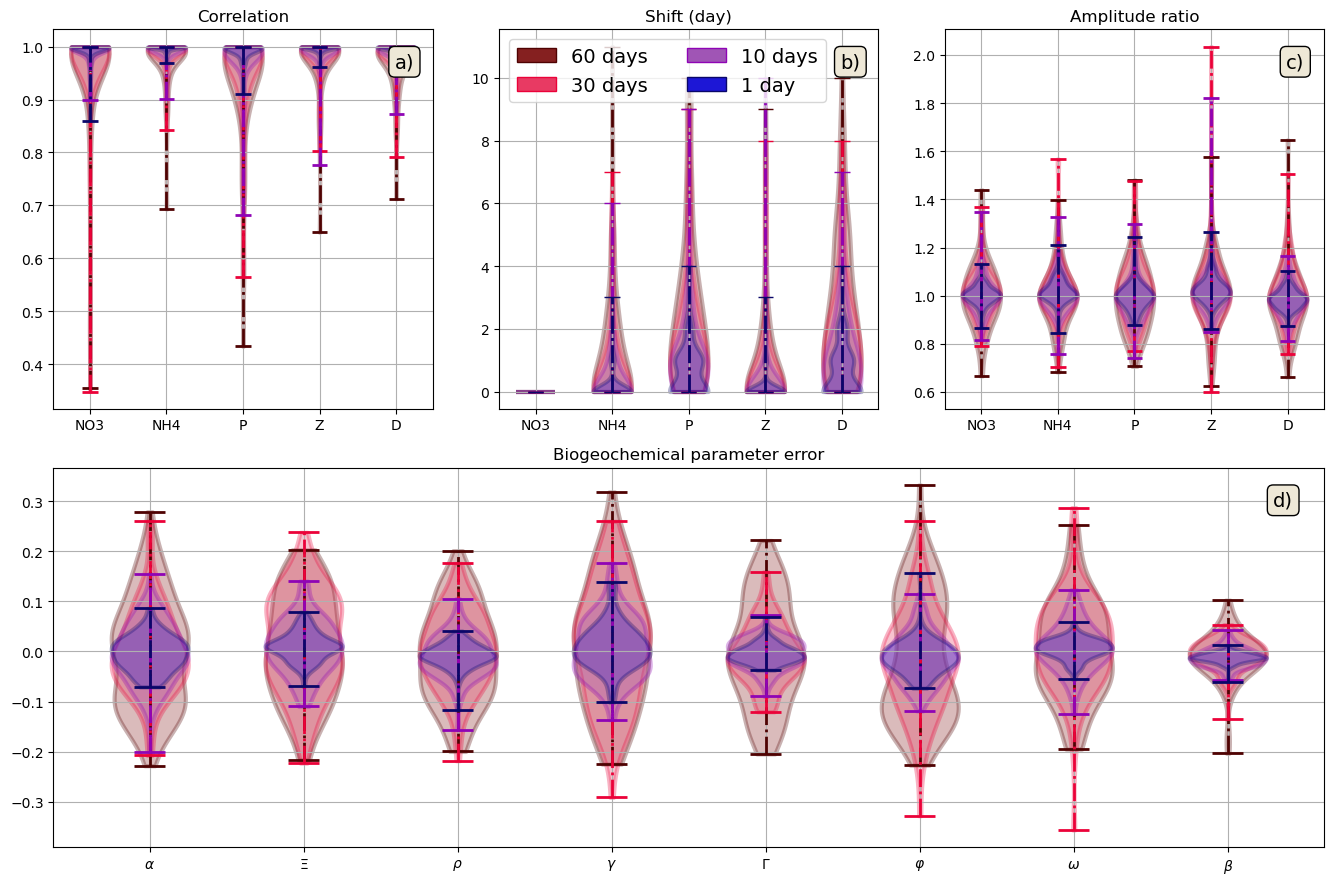

In [3]:
## Colors sampling t
label_case = [f"60 days", f"30 days", f"10 days", f"1 day"]
colors = [["#852020", "#4f0202"], ["#e83a63", "#eb0239"], ["#a055b5", "#8f04b5"], ['#1d17d6', '#0a0769'], ['#85d1d6', '#0ccaa5'], ["#6ce334", "#47de00"]] # brown, red, purple, db, lb, green
fig_file_name = "Violin_plot_NN_t_sampling.png"




fig = plt.figure(figsize=(6.4*2.1, 6.4*0.7*2))
grid = fig.add_gridspec(nrows = 2, ncols=3)
ax_corr = fig.add_subplot(grid[0, 0])
ax_shift = fig.add_subplot(grid[0, 1])
ax_ampl = fig.add_subplot(grid[0, 2])
ax_param = fig.add_subplot(grid[1, :])

ax_corr.set_title('Correlation')
# ax_corr.set_ylim(0.15, 1.05)
ax_shift.set_title('Shift (day)')
# ax_shift.set_ylim(-2, 31)
ax_ampl.set_title("Amplitude ratio")
# ax_ampl.set_ylim(0.2, 2.6)
ax_param.set_title("Biogeochemical parameter error")
# ax_param.set_ylim(-0.42, 0.42)
c_DA, s_DA, r_DA, v_DA = [], [], [], []

compteur = 0
corr, shift, ampl = [], [], []
for i in range(nb_case_stud) :
    corr_step, shift_step, ampl_step = metrics_BGC(torch.sum(States_stud[i, :, :, 30:150]*(zw_ref[1:]-zw_ref[:-1]), dim = -1), torch.sum(States_ref[:, :, 30:150]*(zw_ref[1:]-zw_ref[:-1]), dim = -1))
    corr.append(corr_step.cpu()); shift.append(shift_step.cpu()); ampl.append(ampl_step.cpu())

    c_DA.append(ax_corr.violinplot(corr[i], showextrema=False))
    s_DA.append(ax_shift.violinplot(abs(shift[i]), showextrema=False))
    r_DA.append(ax_ampl.violinplot(ampl[i], showextrema=False))
    v_DA.append(ax_param.violinplot(((Params_stud[i]-Params_ref)/mean_params), showextrema=False))

for j in range(nb_case_stud) :
    for i in range(8) :
        ax_param.vlines(i+1, ((Params_stud[j]-Params_ref)/mean_params)[:, i].min().item(), ((Params_stud[j]-Params_ref)/mean_params)[:, i].max().item(), color=colors[j][1], linestyle='-.', lw=2)
        ax_param.hlines(((Params_stud[j]-Params_ref)/mean_params)[:, i].min().item(), xmin = i+0.9, xmax = i+1.1, color=colors[j][1], linestyle='-', lw=2)
        ax_param.hlines(((Params_stud[j]-Params_ref)/mean_params)[:, i].max().item(), xmin = i+0.9, xmax = i+1.1, color=colors[j][1], linestyle='-', lw=2)

    for i in range(5) :
        ax_corr.vlines(i+1, corr[j][ :, i].min().item(), corr[j][ :, i].max().item(), color=colors[j][1], linestyle='-.', lw=2)
        ax_corr.hlines(corr[j][ :, i].min().item(), xmin = i+0.9, xmax = i+1.1, color=colors[j][1], linestyle='-', lw=2)
        ax_corr.hlines(corr[j][ :, i].max().item(), xmin = i+0.9, xmax = i+1.1, color=colors[j][1], linestyle='-', lw=2)
    
        ax_shift.vlines(i+1, abs(shift[j])[ :, i].min().item(), abs(shift[j])[ :, i].max().item(), color=colors[j][1], linestyle='-.', lw=2)
        ax_shift.hlines(abs(shift[j])[ :, i].min().item(), xmin = i+0.9, xmax = i+1.1, color=colors[j][1], lw=1)
        ax_shift.hlines(abs(shift[j])[ :, i].max().item(), xmin = i+0.9, xmax = i+1.1, color=colors[j][1], lw=1)
    
        ax_ampl.vlines(i+1, ampl[j][ :, i].min().item(), ampl[j][ :, i].max().item(), color=colors[j][1], linestyle='-.', lw=2)
        ax_ampl.hlines(ampl[j][ :, i].min().item(), xmin = i+0.9, xmax = i+1.1, color=colors[j][1], linestyle='-', lw=2)
        ax_ampl.hlines(ampl[j][ :, i].max().item(), xmin = i+0.9, xmax = i+1.1, color=colors[j][1], linestyle='-', lw=2)
    
for compteur in range(nb_case_stud) :
    for pc in v_DA[compteur]['bodies']:
        pc.set_facecolor(colors[compteur][0])
        pc.set_edgecolor(colors[compteur][1])
        pc.set_linewidth(3)
    for pc in c_DA[compteur]['bodies']:
        pc.set_facecolor(colors[compteur][0])
        pc.set_edgecolor(colors[compteur][1])
        pc.set_linewidth(3)
    for pc in s_DA[compteur]['bodies']:
        pc.set_facecolor(colors[compteur][0])
        pc.set_edgecolor(colors[compteur][1])
        pc.set_linewidth(3)
    for pc in r_DA[compteur]['bodies']:
        pc.set_facecolor(colors[compteur][0])
        pc.set_edgecolor(colors[compteur][1])
        pc.set_linewidth(3)


ax_corr.text(s = "a)", x = get_rightcorner(ax_corr, 0.9), y = get_topcorner(ax_corr, 0.9), bbox = dict(boxstyle="round", fc="#eee8d7", alpha = 1), fontsize = 14)
ax_shift.text(s = "b)", x = get_rightcorner(ax_shift, 0.9), y = get_topcorner(ax_shift, 0.9), bbox = dict(boxstyle="round", fc="#eee8d7", alpha = 1), fontsize = 14)
ax_ampl.text(s = "c)", x = get_rightcorner(ax_ampl, 0.9), y = get_topcorner(ax_ampl, 0.9), bbox = dict(boxstyle="round", fc="#eee8d7", alpha = 1), fontsize = 14)
ax_param.text(s = "d)", x = get_rightcorner(ax_param, 0.96), y = get_topcorner(ax_param, 0.9), bbox = dict(boxstyle="round", fc="#eee8d7", alpha = 1), fontsize = 14)

comp_legend=[]
for i in range(nb_case_stud) :
    comp_legend.append(mpatches.Patch(color=colors[i][0], ec = colors[i][1], label=label_case[i]))

ax_shift.legend(handles=comp_legend, loc = 'upper left', fontsize = 14, ncol=2)
for ax in [ax_corr, ax_shift, ax_ampl] :
    ax.grid()
    ax.set_xticks([1, 2, 3, 4, 5], ["NO3", "NH4", "P", "Z", "D"])

ax_param.grid()
ax_param.set_xticks(torch.arange(1, 9, 1).cpu(), [r"$\alpha$", r"$\Xi$", r"$\rho$", r"$\gamma$", r"$\Gamma$", r"$\varphi$", r"$\omega$", r"$\beta$"])
plt.rc('axes', titlesize=14)
plt.rc('axes', labelsize=14) #fontsize of the x and y labels
plt.rc('xtick', labelsize=14) #fontsize of the x tick labels
plt.rc('ytick', labelsize=14) #fontsize of the y tick labels

plt.subplots_adjust(bottom=0.15, wspace=0.15)
# fig.suptitle("Case 1 - CTD + Rosette - Daily obs")
fig.tight_layout()

fig.savefig(fig_file_name, dpi=300)


## Vertical sampling strategy

In [15]:
list_file_name = [
                  f"Res/NN/Case1_1sample10days_strat3/",
                  f"Res/NN/Case1_1sample10days_strat2/",
                  f"Res/NN/Case1_1sample10days_strat1/",
                  f"Res/NN/Case1_1sample10days_strat0/"
                 ]
nb_case_stud = len(list_file_name)
States_stud = torch.tensor([], device=devices[0])
Params_stud = torch.tensor([], device=devices[0])
folder_name = ""
for i in range(nb_case_stud) :
    nb_version = -1
    for file in os.listdir(folder_name+list_file_name[i]) :
        if file[:8] == "Version_" :
            nb_version += 1
    States_stud = torch.cat((States_stud, torch.load(folder_name+list_file_name[i]+f"Version_{nb_version}/pred_var/States_reconstruct.pt", weights_only=False, map_location=devices[0])[None, :, :, -365:]), dim = 0)
    Params_stud = torch.cat((Params_stud, torch.load(folder_name+list_file_name[i]+f"Version_{nb_version}/pred_var/Params_pred_ens.pt", weights_only=False, map_location=devices[0]).mean(0)[None]), dim = 0)

States_ref = torch.load(f"Generated_Datasets/Case_{0}/States.pt", weights_only=False, map_location=devices[0])[-100:, :, -365:].clone()
Params_ref=torch.load(f"Generated_Datasets/Case_{0}/Params.pt", weights_only=False, map_location=devices[0])[0, -100:]
mean_params=torch.load("Generated_Datasets/Case_0/Params_mean.pt", weights_only=False, map_location=devices[0])
std_params=torch.load("Generated_Datasets/Case_0/Params_std.pt", weights_only=False, map_location=devices[0])

zmax = 350
N_sample = 100
path = 'FORCING_40km/'
Nz = np.argmin(np.load(path+"depth.npy")[0] < zmax)
zrangew_Kz = torch.from_numpy(np.load(path+"depthw.npy"))
z_ref = torch.from_numpy(np.load(path+"depth.npy")[0, :Nz])
zw_ref = torch.from_numpy(np.load(path+"depthw.npy")[0, :Nz+1])

print("Files loaded")

Files loaded


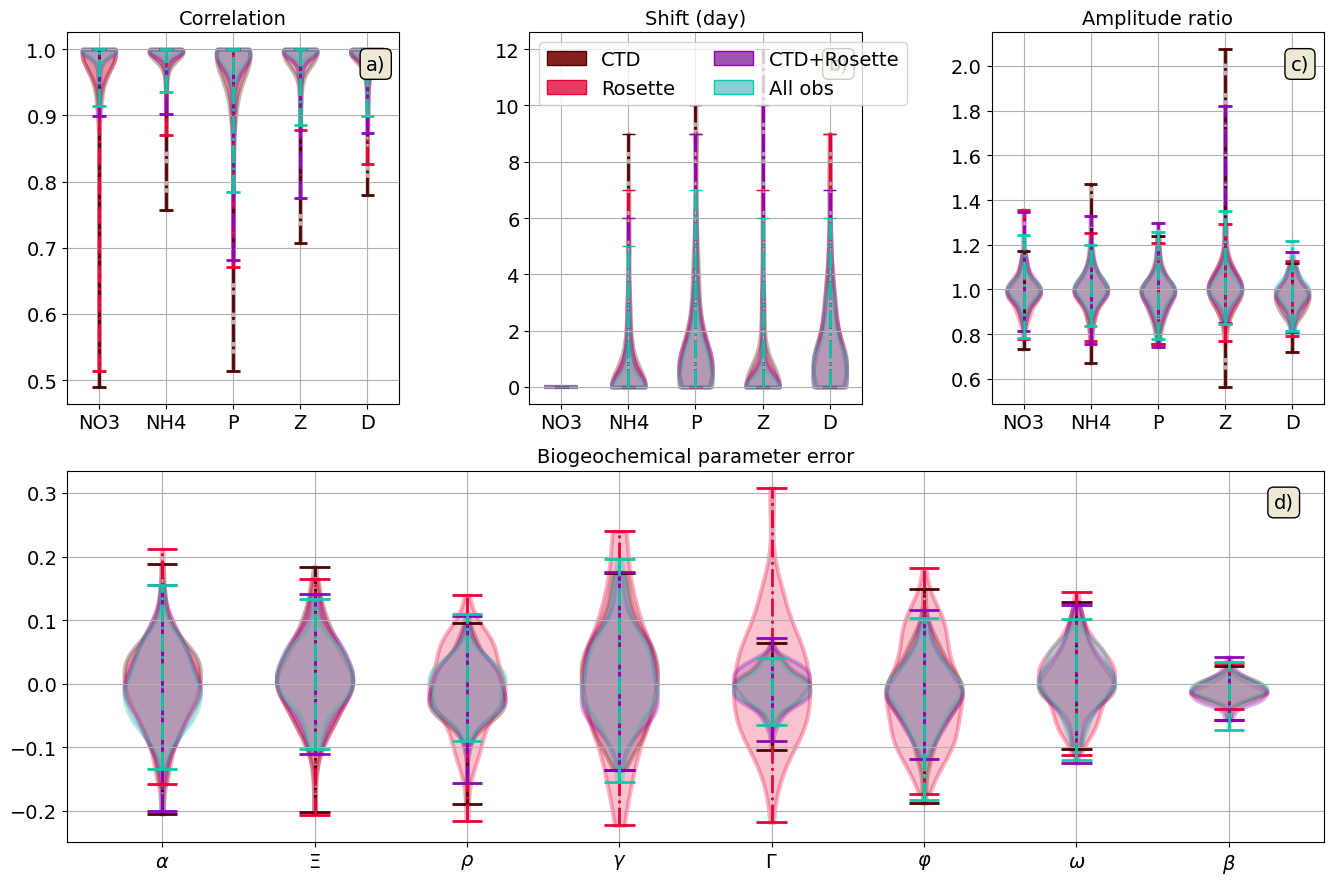

In [16]:
## Colors sampling Z
label_case = [f"CTD", f"Rosette", f"CTD+Rosette", f"All obs"]
colors = [["#852020", "#4f0202"], ["#e83a63", "#eb0239"], ["#a055b5", "#8f04b5"], ['#85d1d6', '#0ccaa5'], ["#6ce334", "#47de00"]] # brown, red, purple, lb
fig_file_name = "Violin_plot_NN_Z_sampling.png"



fig = plt.figure(figsize=(6.4*2.1, 6.4*0.7*2))
grid = fig.add_gridspec(nrows = 2, ncols=3)
ax_corr = fig.add_subplot(grid[0, 0])
ax_shift = fig.add_subplot(grid[0, 1])
ax_ampl = fig.add_subplot(grid[0, 2])
ax_param = fig.add_subplot(grid[1, :])

ax_corr.set_title('Correlation')
# ax_corr.set_ylim(0.15, 1.05)
ax_shift.set_title('Shift (day)')
# ax_shift.set_ylim(-2, 31)
ax_ampl.set_title("Amplitude ratio")
# ax_ampl.set_ylim(0.2, 2.6)
ax_param.set_title("Biogeochemical parameter error")
# ax_param.set_ylim(-0.42, 0.42)
c_DA, s_DA, r_DA, v_DA = [], [], [], []

compteur = 0
corr, shift, ampl = [], [], []
for i in range(nb_case_stud) :
    corr_step, shift_step, ampl_step = metrics_BGC(torch.sum(States_stud[i, :, :, 30:150]*(zw_ref[1:]-zw_ref[:-1]), dim = -1), torch.sum(States_ref[:, :, 30:150]*(zw_ref[1:]-zw_ref[:-1]), dim = -1))
    corr.append(corr_step.cpu()); shift.append(shift_step.cpu()); ampl.append(ampl_step.cpu())

    c_DA.append(ax_corr.violinplot(corr[i], showextrema=False))
    s_DA.append(ax_shift.violinplot(abs(shift[i]), showextrema=False))
    r_DA.append(ax_ampl.violinplot(ampl[i], showextrema=False))
    v_DA.append(ax_param.violinplot(((Params_stud[i]-Params_ref)/mean_params), showextrema=False))

for j in range(nb_case_stud) :
    for i in range(8) :
        ax_param.vlines(i+1, ((Params_stud[j]-Params_ref)/mean_params)[:, i].min().item(), ((Params_stud[j]-Params_ref)/mean_params)[:, i].max().item(), color=colors[j][1], linestyle='-.', lw=2)
        ax_param.hlines(((Params_stud[j]-Params_ref)/mean_params)[:, i].min().item(), xmin = i+0.9, xmax = i+1.1, color=colors[j][1], linestyle='-', lw=2)
        ax_param.hlines(((Params_stud[j]-Params_ref)/mean_params)[:, i].max().item(), xmin = i+0.9, xmax = i+1.1, color=colors[j][1], linestyle='-', lw=2)

    for i in range(5) :
        ax_corr.vlines(i+1, corr[j][ :, i].min().item(), corr[j][ :, i].max().item(), color=colors[j][1], linestyle='-.', lw=2)
        ax_corr.hlines(corr[j][ :, i].min().item(), xmin = i+0.9, xmax = i+1.1, color=colors[j][1], linestyle='-', lw=2)
        ax_corr.hlines(corr[j][ :, i].max().item(), xmin = i+0.9, xmax = i+1.1, color=colors[j][1], linestyle='-', lw=2)
    
        ax_shift.vlines(i+1, abs(shift[j])[ :, i].min().item(), abs(shift[j])[ :, i].max().item(), color=colors[j][1], linestyle='-.', lw=2)
        ax_shift.hlines(abs(shift[j])[ :, i].min().item(), xmin = i+0.9, xmax = i+1.1, color=colors[j][1], lw=1)
        ax_shift.hlines(abs(shift[j])[ :, i].max().item(), xmin = i+0.9, xmax = i+1.1, color=colors[j][1], lw=1)
    
        ax_ampl.vlines(i+1, ampl[j][ :, i].min().item(), ampl[j][ :, i].max().item(), color=colors[j][1], linestyle='-.', lw=2)
        ax_ampl.hlines(ampl[j][ :, i].min().item(), xmin = i+0.9, xmax = i+1.1, color=colors[j][1], linestyle='-', lw=2)
        ax_ampl.hlines(ampl[j][ :, i].max().item(), xmin = i+0.9, xmax = i+1.1, color=colors[j][1], linestyle='-', lw=2)
    
for compteur in range(nb_case_stud) :
    for pc in v_DA[compteur]['bodies']:
        pc.set_facecolor(colors[compteur][0])
        pc.set_edgecolor(colors[compteur][1])
        pc.set_linewidth(3)
    for pc in c_DA[compteur]['bodies']:
        pc.set_facecolor(colors[compteur][0])
        pc.set_edgecolor(colors[compteur][1])
        pc.set_linewidth(3)
    for pc in s_DA[compteur]['bodies']:
        pc.set_facecolor(colors[compteur][0])
        pc.set_edgecolor(colors[compteur][1])
        pc.set_linewidth(3)
    for pc in r_DA[compteur]['bodies']:
        pc.set_facecolor(colors[compteur][0])
        pc.set_edgecolor(colors[compteur][1])
        pc.set_linewidth(3)


ax_corr.text(s = "a)", x = get_rightcorner(ax_corr, 0.9), y = get_topcorner(ax_corr, 0.9), bbox = dict(boxstyle="round", fc="#eee8d7", alpha = 1), fontsize = 14)
ax_shift.text(s = "b)", x = get_rightcorner(ax_shift, 0.9), y = get_topcorner(ax_shift, 0.9), bbox = dict(boxstyle="round", fc="#eee8d7", alpha = 1), fontsize = 14)
ax_ampl.text(s = "c)", x = get_rightcorner(ax_ampl, 0.9), y = get_topcorner(ax_ampl, 0.9), bbox = dict(boxstyle="round", fc="#eee8d7", alpha = 1), fontsize = 14)
ax_param.text(s = "d)", x = get_rightcorner(ax_param, 0.96), y = get_topcorner(ax_param, 0.9), bbox = dict(boxstyle="round", fc="#eee8d7", alpha = 1), fontsize = 14)

comp_legend=[]
for i in range(nb_case_stud) :
    comp_legend.append(mpatches.Patch(color=colors[i][0], ec = colors[i][1], label=label_case[i]))

ax_shift.legend(handles=comp_legend, loc = 'upper left', fontsize = 14, ncol=2)
for ax in [ax_corr, ax_shift, ax_ampl] :
    ax.grid()
    ax.set_xticks([1, 2, 3, 4, 5], ["NO3", "NH4", "P", "Z", "D"])

ax_param.grid()
ax_param.set_xticks(torch.arange(1, 9, 1).cpu(), [r"$\alpha$", r"$\Xi$", r"$\rho$", r"$\gamma$", r"$\Gamma$", r"$\varphi$", r"$\omega$", r"$\beta$"])
plt.rc('axes', titlesize=14)
plt.rc('axes', labelsize=14) #fontsize of the x and y labels
plt.rc('xtick', labelsize=14) #fontsize of the x tick labels
plt.rc('ytick', labelsize=14) #fontsize of the y tick labels

plt.subplots_adjust(bottom=0.15, wspace=0.15)
# fig.suptitle("Case 1 - CTD + Rosette - Daily obs")
fig.tight_layout()

fig.savefig(fig_file_name, dpi=300)


# Scatter plot

In [45]:
list_file_name = [
                  f"Res/NN/Case1_1sample60days_strat1/",
                  f"Res/NN/Case1_1sample30days_strat1/",
                  f"Res/NN/Case1_1sample10days_strat1/",
                  f"Res/NN/Case1_1sample1days_strat1/"
                 ]
nb_case_stud = len(list_file_name)
States_stud = torch.tensor([], device=devices[0])
Params_stud = torch.tensor([], device=devices[0])
folder_name = ""
for i in range(nb_case_stud) :
    nb_version = -1
    for file in os.listdir(folder_name+list_file_name[i]) :
        if file[:8] == "Version_" :
            nb_version += 1
    States_stud = torch.cat((States_stud, torch.load(folder_name+list_file_name[i]+f"Version_{nb_version}/pred_var/States_reconstruct.pt", weights_only=False, map_location=devices[0])[None, :, :, -365:]), dim = 0)
    Params_stud = torch.cat((Params_stud, torch.load(folder_name+list_file_name[i]+f"Version_{nb_version}/pred_var/Params_pred_ens.pt", weights_only=False, map_location=devices[0]).mean(0)[None]), dim = 0)

States_ref = torch.load(f"Generated_Datasets/Case_{0}/States.pt", weights_only=False, map_location=devices[0])[-100:, :, -365:].clone()
Params_ref=torch.load(f"Generated_Datasets/Case_{0}/Params.pt", weights_only=False, map_location=devices[0])[0, -100:]
std_params=torch.load("Generated_Datasets/Case_0/Params_std.pt", weights_only=False, map_location=devices[0])
std_states=torch.load("Generated_Datasets/Case_0/States_std.pt", weights_only=False, map_location=devices[0])

zmax = 350
N_sample = 100
path = 'FORCING_40km/'
Nz = np.argmin(np.load(path+"depth.npy")[0] < zmax)
zrangew_Kz = torch.from_numpy(np.load(path+"depthw.npy"))
z_ref = torch.from_numpy(np.load(path+"depth.npy")[0, :Nz])
zw_ref = torch.from_numpy(np.load(path+"depthw.npy")[0, :Nz+1])

print("Files loaded")

Files loaded


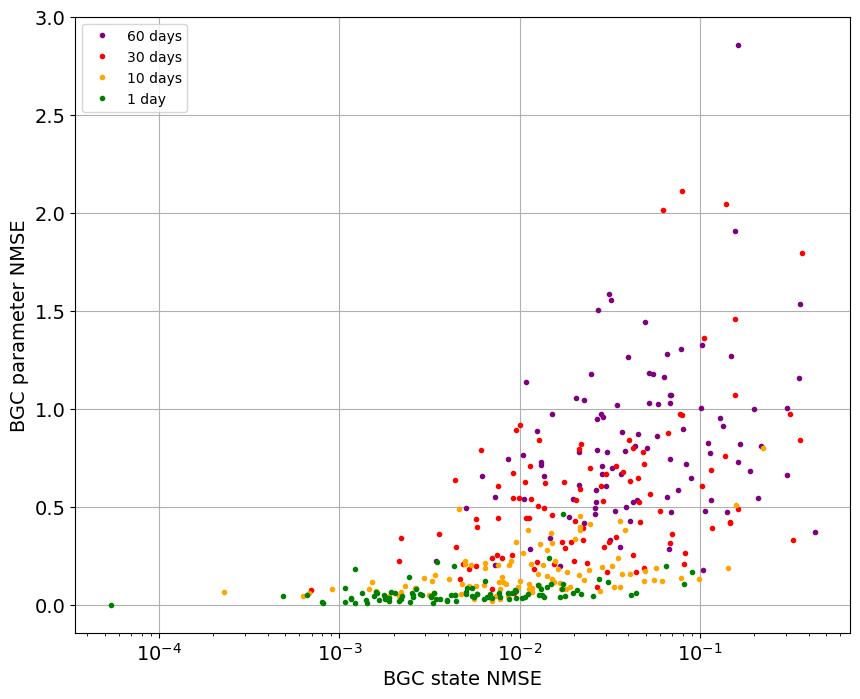

In [49]:
plt.figure(figsize=[10, 8])
for scenario in range(nb_case_stud) :
    plt.semilogx(torch.mean(((States_stud[scenario]-States_ref).moveaxis(1,3)/std_states)**2, dim=(1, 2, 3)) ,
                 torch.mean(((Params_stud[scenario]-Params_ref)/std_params)**2, dim=-1), color=['purple', 'red', 'orange', 'green'][scenario], label=["60 days", "30 days", "10 days", "1 day"][scenario], marker='.', ls=' ')
plt.xlabel("BGC state NMSE")
plt.ylabel("BGC parameter NMSE")
plt.legend(loc='upper left')
plt.grid()
plt.savefig("Scatter_plot_NN_dt.png", dpi=300)